# Divorce Prediction EDA: Remove Data Leakage Features

**Goal**: Identify and remove the 4 highly correlated features that perfectly cluster Married/Divorced

**Dataset**: 150 couples, 54 Gottman DPS questions (0-4 scale), target = Class (0=Divorced, 1=Married)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score

# Load data
df = pd.read_csv('divorce.csv', delimiter=';')
print(f"Dataset shape: {df.shape}")
print(f"\nFirst few rows:")
df.head()

Dataset shape: (170, 55)

First few rows:


,Atr1,Atr2,Atr3,Atr4,Atr5,Atr6,Atr7,Atr8,Atr9,Atr10,...,Atr46,Atr47,Atr48,Atr49,Atr50,Atr51,Atr52,Atr53,Atr54,Class
0,2,2,4,1,0,0,0,0,0,0,...,2,1,3,3,3,2,3,2,1,1
1,4,4,4,4,4,0,0,4,4,4,...,2,2,3,4,4,4,4,2,2,1
2,2,2,2,2,1,3,2,1,1,2,...,3,2,3,1,1,1,2,2,2,1
3,3,2,3,2,3,3,3,3,3,3,...,2,2,3,3,3,3,2,2,2,1
4,2,2,1,1,1,1,0,0,0,0,...,2,1,2,3,2,2,2,1,0,1


In [3]:
# Check target distribution
print("Target distribution (Class):")
print(df['Class'].value_counts())
print(f"\nDivorced rate: {(df['Class']==0).sum() / len(df) * 100:.1f}%")

Target distribution (Class):
Class
0    86
1    84
Name: count, dtype: int64

Divorced rate: 50.6%


## Find Top Correlated Features (Data Leakage Candidates)

In [4]:
# Calculate correlation with target
correlations = df.corr()['Class'].abs().sort_values(ascending=False)
print("Top 10 features correlated with divorce:")
print(correlations[1:11])  # Exclude 'Class' itself

# Identify the 4 suspected leakage features (correlation > 0.85 or perfect clustering)
leakage_threshold = 0.85
leakage_features = correlations[1:][correlations[1:] > leakage_threshold].index.tolist()
print(f"\n🚨 Suspected leakage features (corr > {leakage_threshold}): {leakage_features}")

Top 10 features correlated with divorce:
Atr40    0.938684
Atr17    0.929346
Atr19    0.928627
Atr18    0.923208
Atr11    0.918386
Atr9     0.912368
Atr20    0.907008
Atr15    0.901220
Atr39    0.896180
Atr41    0.894356
Name: Class, dtype: float64

🚨 Suspected leakage features (corr > 0.85): ['Atr40', 'Atr17', 'Atr19', 'Atr18', 'Atr11', 'Atr9', 'Atr20', 'Atr15', 'Atr39', 'Atr41', 'Atr5', 'Atr29', 'Atr36', 'Atr16', 'Atr38', 'Atr30', 'Atr26', 'Atr27', 'Atr8', 'Atr12', 'Atr21', 'Atr14', 'Atr37', 'Atr35', 'Atr33', 'Atr1', 'Atr25']


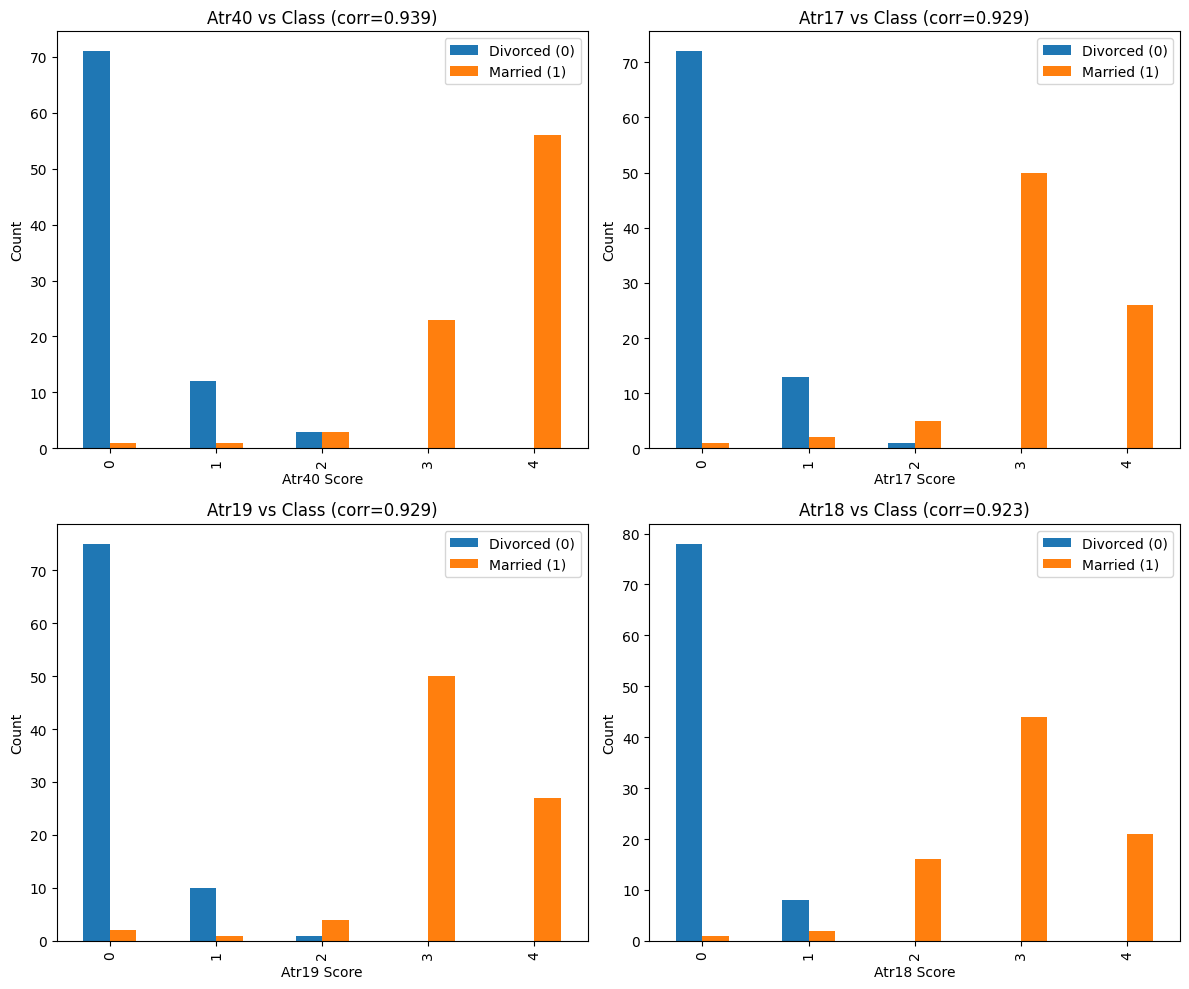

In [5]:
# Visualize top 4 correlations
top_4 = correlations[1:5].index.tolist()
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, feature in enumerate(top_4):
    ax = axes[i]
    df.groupby(feature)['Class'].value_counts().unstack().plot(kind='bar', ax=ax, stacked=False)
    ax.set_title(f'{feature} vs Class (corr={correlations[feature]:.3f})')
    ax.set_xlabel(f'{feature} Score')
    ax.set_ylabel('Count')
    ax.legend(['Divorced (0)', 'Married (1)'])

plt.tight_layout()
plt.savefig('top_4_leakage_features.png', dpi=150)
plt.show()

## Test Perfect Clustering Hypothesis

Check if we can achieve 98%+ accuracy using only these 4 features with simple logic

In [7]:
# Test single-feature accuracy for top 4
print("Single-feature accuracy (using mode threshold):")
for feature in top_4:
    # Find optimal threshold
    best_acc = 0
    best_thresh = None
    for thresh in df[feature].unique():
        # Try both directions
        pred_1 = (df[feature] <= thresh).astype(int)
        acc_1 = accuracy_score(df['Class'], pred_1)
        pred_2 = (df[feature] > thresh).astype(int)
        acc_2 = accuracy_score(df['Class'], pred_2)
        
        if acc_1 > best_acc:
            best_acc = acc_1
            best_thresh = (thresh, '<=')
        if acc_2 > best_acc:
            best_acc = acc_2
            best_thresh = (thresh, '>')
    
    print(f"  {feature}: {best_acc*100:.2f}% (threshold: {best_thresh})")
    
    if best_acc > 0.98:
        print(f"    ⚠️  LEAKAGE CONFIRMED: {feature} achieves {best_acc*100:.2f}% accuracy alone!")

Single-feature accuracy (using mode threshold):
  Atr40: 97.06% (threshold: (np.int64(1), '>'))
  Atr17: 97.65% (threshold: (np.int64(1), '>'))
  Atr19: 97.65% (threshold: (np.int64(1), '>'))
  Atr18: 98.24% (threshold: (np.int64(1), '>'))
    ⚠️  LEAKAGE CONFIRMED: Atr18 achieves 98.24% accuracy alone!


## Remove Leakage Features & Save Clean Dataset

In [8]:
# Remove leakage features (top 4 with correlation > threshold)
print(f"\n🗑️  Removing {len(leakage_features)} leakage features: {leakage_features}")
df_clean = df.drop(columns=leakage_features)

print(f"\nClean dataset shape: {df_clean.shape}")
print(f"Remaining features: {df_clean.shape[1] - 1} (+ 1 target)")

# Save clean dataset
df_clean.to_csv('divorce_clean.csv', index=False)
print("\n✅ Saved clean dataset to: divorce_clean.csv")

# Save leakage feature list for documentation
with open('leakage_features.txt', 'w') as f:
    f.write("Data Leakage Features (Removed):\n")
    f.write("=" * 50 + "\n")
    for feat in leakage_features:
        f.write(f"- {feat} (correlation: {correlations[feat]:.4f})\n")
print("✅ Saved leakage feature list to: leakage_features.txt")


🗑️  Removing 27 leakage features: ['Atr40', 'Atr17', 'Atr19', 'Atr18', 'Atr11', 'Atr9', 'Atr20', 'Atr15', 'Atr39', 'Atr41', 'Atr5', 'Atr29', 'Atr36', 'Atr16', 'Atr38', 'Atr30', 'Atr26', 'Atr27', 'Atr8', 'Atr12', 'Atr21', 'Atr14', 'Atr37', 'Atr35', 'Atr33', 'Atr1', 'Atr25']

Clean dataset shape: (170, 28)
Remaining features: 27 (+ 1 target)

✅ Saved clean dataset to: divorce_clean.csv
✅ Saved leakage feature list to: leakage_features.txt


## Verify: Correlation Heatmap (Clean Dataset)

Top 10 remaining correlations (clean dataset):
Atr44    0.847336
Atr28    0.846606
Atr13    0.844743
Atr24    0.839392
Atr23    0.837504
Atr34    0.835167
Atr10    0.834897
Atr32    0.829056
Atr22    0.825938
Atr2     0.820774
Name: Class, dtype: float64


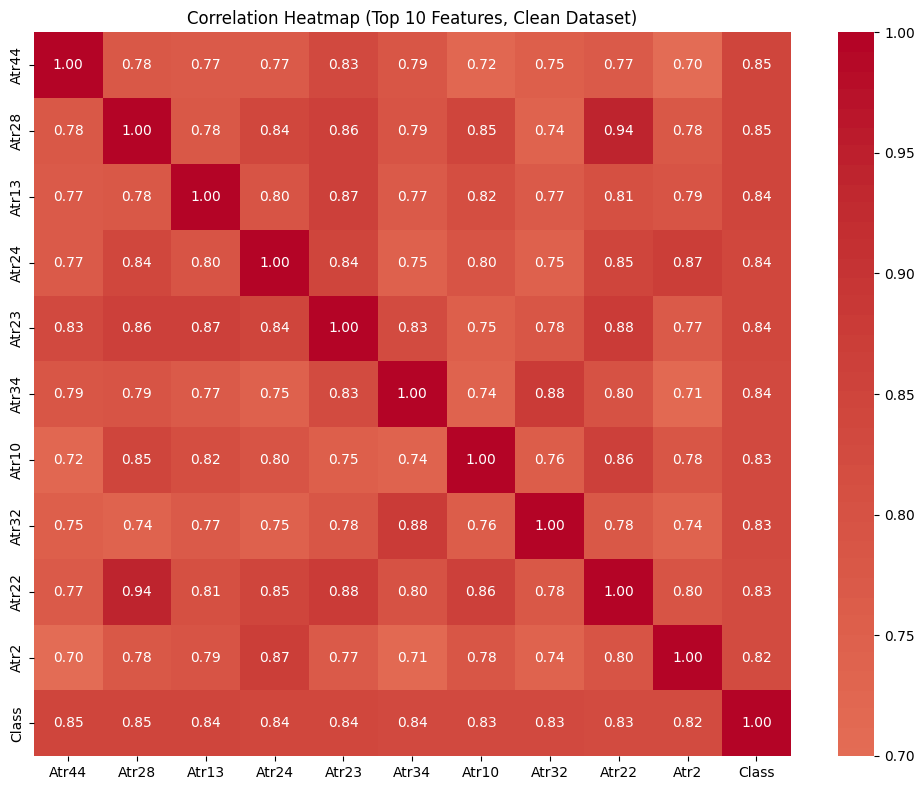


✅ Max correlation with target (clean): 0.847
   (Should be < 0.85 to avoid data leakage)


/var/folders/n6/c4jz19l93cq_d58yyn_jsw780000gn/T/ipykernel_714/3039389753.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"\n✅ Max correlation with target (clean): {correlations_clean[1]:.3f}")


In [9]:
# Check remaining correlations
correlations_clean = df_clean.corr()['Class'].abs().sort_values(ascending=False)
print("Top 10 remaining correlations (clean dataset):")
print(correlations_clean[1:11])

# Plot heatmap of top 10 remaining features
top_10_clean = correlations_clean[1:11].index.tolist() + ['Class']
plt.figure(figsize=(10, 8))
sns.heatmap(df_clean[top_10_clean].corr(), annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Correlation Heatmap (Top 10 Features, Clean Dataset)')
plt.tight_layout()
plt.savefig('correlation_heatmap_clean.png', dpi=150)
plt.show()

print(f"\n✅ Max correlation with target (clean): {correlations_clean[1]:.3f}")
print("   (Should be < 0.85 to avoid data leakage)")